In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

**Time Series** is a class of data science problems where the primary values of interest are a series of data points measured over a period of time. This notebook aims to provide the basic building blocks of some of the more modern algorithms / techniques (and data!) for solving these types of problems.

Is ARIMA the first thing you think of when you hear about time series? It might be time to explore other ventures and methodologies. There is a lot of new innovation and modern techniques being actively developed and some of them are outperforming the traditional ARIMA models. We'll look at some of these models and try to apply them on stock market data to predict price.

Models explored in this notebook:

1. Auto ARIMAX
2. LightGBM

**Nifty-50 Stock Market Data**

The dataset used is stock market data of the Nifty-50 index from NSE (National Stock Exchange) India over the last 20 years (2000 - 2019)

The historic VWAP (Volume Weighted Average Price) is the target variable to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.
Read more about the dataset: https://www.kaggle.com/rohanrao/nifty50-stock-market-data

The stock used is BAJAJFINSV.

### Data Preparation

Reading the market data of BAJAJFINSV stock and preparing a training dataset and validation dataset.

In [2]:
df = pd.read_csv("BAJAJFINSV.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


Plotting the target variable VWAP over time

<AxesSubplot:xlabel='Date'>

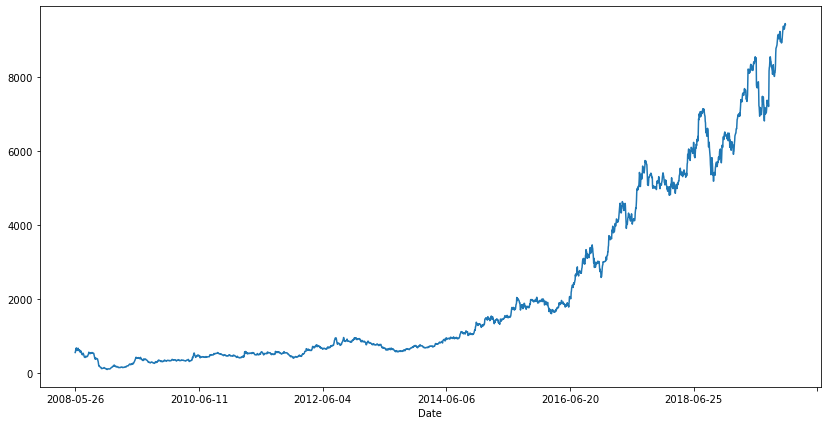

In [3]:
df.VWAP.plot(figsize=(14, 7))

### Feature Engineering

Almost every time series problem will have some external features or some internal feature engineering to help the model.

Let's add some basic features like lag values of available numeric features that are widely used for time series problems. Since we need to predict the price of the stock for a day, we cannot use the feature values of the same day since they will be unavailable at actual inference time. We need to use statistics like mean, standard deviation of their lagged values.

We will use three sets of lagged values, one previous day, one looking back 7 days and another looking back 30 days as a proxy for last week and last month metrics.

In [4]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13164\3792767483.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,...,4.316068e+13,1.685418e+13,2.160474e+13,2.963513e+13,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,...,1.726368e+14,1.685418e+13,2.160474e+13,2.963513e+13,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,...,2.107369e+14,5.388164e+13,5.388164e+13,5.388164e+13,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,...,2.350756e+14,5.682195e+13,5.682195e+13,5.682195e+13,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,...,2.508797e+14,2.541759e+13,5.613884e+13,5.613884e+13,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691


For boosting models(LightGBM), it is very useful to add datetime features like hour, day, month, as applicable to provide the model information about the time component in the data. For time series models it is not explicitly required to pass this information but we could do so and we will in this notebook so that all models are compared on the exact same set of features.

In [5]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13164\2560288566.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,...,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691,5,22,26,0
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,...,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691,5,22,27,1
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,...,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691,5,22,28,2
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,...,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691,5,22,29,3
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,...,12089.546875,12078.219727,12015.113281,4340.279785,5418.928711,7087.783691,5,22,30,4


Splitting the data into train and validation along with features.

train: Data from 26th May, 2008 to 31st December, 2018.
valid: Data from 1st January, 2019 to 31st December, 2019.

In [6]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

The additional features supplied to time series problems are called exogenous regressors.

### Auto ARIMAX

ARIMA (Auto Regressive Integrated Moving Average) models explain a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

ARIMA models require certain input parameters: p for the AR(p) part, q for the MA(q) part and d for the I(d) part. Thankfully, there is an automatic process by which these parameters can be chosen which is called Auto ARIMA.

When exogenous regressors are used with ARIMA it is commonly called ARIMAX.

Read more about ARIMA: https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

In [7]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=28695.849, Time=6.79 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=29360.430, Time=4.29 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28786.582, Time=4.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=29047.794, Time=5.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47416.470, Time=3.87 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=28697.680, Time=6.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=28693.796, Time=6.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=28770.132, Time=5.99 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=28702.730, Time=6.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=28708.103, Time=6.92 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=28694.683, Time=6.82 sec


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=30584.464, Time=7.51 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=28691.584, Time=6.62 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=28767.930, Time=6.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=28700.723, Time=5.91 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=28705.995, Time=6.41 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=28693.536, Time=6.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=28783.853, Time=4.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=28695.577, Time=6.27 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=28692.546, Time=6.41 sec


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=30582.234, Time=6.55 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 125.673 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13164\395220638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_ARIMAX"] = forecast


Plotting the target variable VWAP & Forecast ARIMA over time

<AxesSubplot:xlabel='Date'>

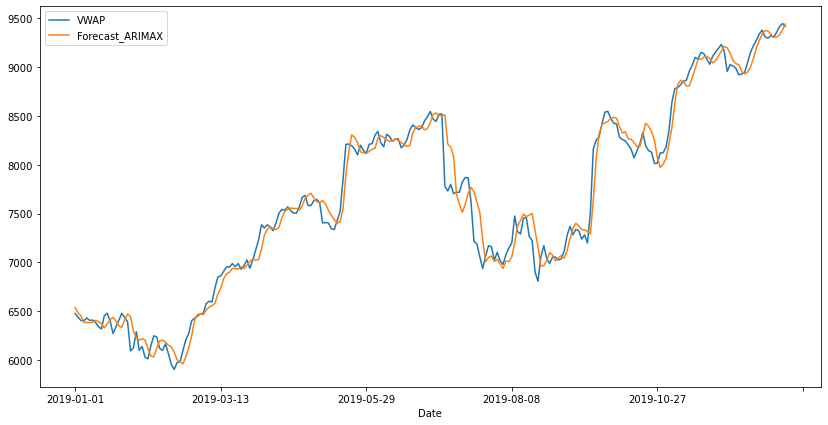

In [8]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [9]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 147.08063746438037

MAE of Auto ARIMAX: 104.03230684014659


The Auto ARIMAX model seems to do a fairly good job in predicting the stock price given data till the previous day. Can other models beat this benchmark?

### LightGBM

Time series problems are popularly converted into a tabular i.i.d. structure and fed into boosting models like LightGBM and XGBoost.

There is loss of information in terms of knowing the order of data points in the time series but it can be circumvented by the datetime features to capture this information to some extent.

Note that the default parameters are used for LightGBM. They can be tuned to improve the results.

In [10]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7756
[LightGBM] [Info] Number of data points in the train set: 2627, number of used features: 34
[LightGBM] [Info] Start training from score 1703.363246


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13164\910916039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_LightGBM"] = forecast


Plotting the target variable VWAP, Forecast ARIMA & Forecast LightGBM over time

<AxesSubplot:xlabel='Date'>

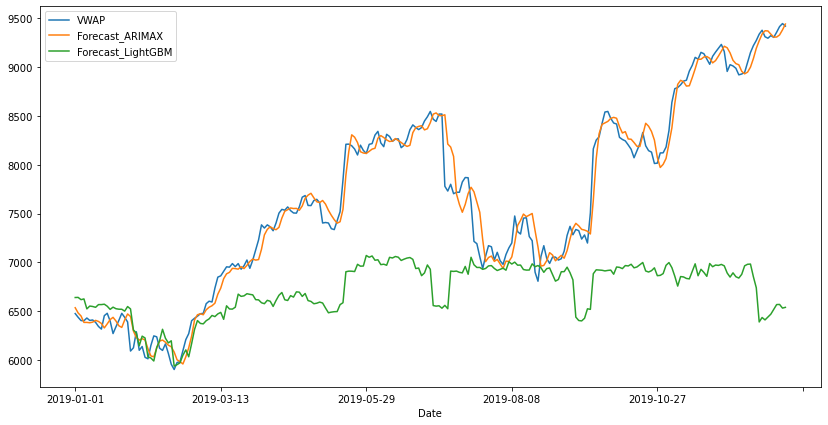

In [11]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_LightGBM"]].plot(figsize=(14, 7))

In [12]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of LightGBM:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_LightGBM))

RMSE of Auto ARIMAX: 147.08063746438037
RMSE of LightGBM: 1233.324223074174

MAE of Auto ARIMAX: 104.03230684014659
MAE of LightGBM: 959.1394397279743


LightGBM performs terribly! This is a very important aspect of using boosting models for time series. Remember that boosting models are constrained to predict within the range of target values appearing in the training data. The maximum price value in the training data is ~ 7100 and hence LGBM is unable to predict values beyond 7100.

Then why are boosting methods still so popular? Well, they fail only in cases where the trend component is extremely strong and there are a wide variety of use cases where the trend is weak and the expected forecasts are within the values of the past. Stock prices is an example that generally has strong trend components especially when measured over years.

Conclusions and Tips

1. Auto ARIMAX is a great baseline model.
2. Setting up an appropriate validation framework is extremely important. It enables you to try and experiment various models and objectively compare them.
3. Lag-based features are very useful in providing trends information about the time series data. Rolling statistics are a common way of generating these.
4. Exogenous regressors help in providing external information about the time series. They tend to be very important in most models.
5. Boosting models like LightGBM are constrained to predict within the range of values of the target variable in the training data and don't extrapolate when there is strong trend.
6. Converting a time series to stationary and then modelling is a common approach for building solutions and can significantly improve results.